In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import pandas as pd
import numpy as np

### Data Manipulation
In the first section of this notebook, I downloaded the scraped data and reformatted it so that I have a dataframe that
records how many goals each team scored in each game and who they scored those goals against

In [2]:
#Load data from CSV, isolate relevant columns
df = pd.read_csv("football.csv")
score_df = df[['home_team','home_goals','away_team','away_goals']]
display(score_df)

,home_team,home_goals,away_team,away_goals
0,Liverpool,4,Norwich City,1
1,Brighton,3,Tottenham,0
2,Arsenal,1,Bournemouth,0
3,Manchester Utd,1,Arsenal,1
4,Burnley,1,Everton,0
...,...,...,...,...
375,Crystal Palace,0,Everton,0
376,Burnley,3,Southampton,0
377,West Ham,0,Manchester City,5
378,Watford,0,Brighton,3


In [3]:
#Create two dataframes that record how many goals a team scored against an opponent for each game,one for home and one for away.
#Then combine them and aggregate to get the total number of goals each team scored on each other team

home_df = score_df.rename(columns = {'home_team':'score_team','home_goals':'goals','away_team':'target'}).drop('away_goals',1)
away_df = score_df.rename(columns = {'away_team':'score_team','away_goals':'goals','home_team':'target'}).drop('home_goals',1)
away_df = away_df[['score_team','goals','target']]
goals_df = home_df.append(away_df,ignore_index=True)
goals_df = goals_df.groupby(['score_team','target']).agg(goals = ('goals','sum')).reset_index()



In [4]:
display(goals_df)

,score_team,target,goals
0,Arsenal,Aston Villa,3
1,Arsenal,Bournemouth,2
2,Arsenal,Brighton,2
3,Arsenal,Burnley,2
4,Arsenal,Chelsea,3
...,...,...,...
375,Wolves,Sheffield Utd,1
376,Wolves,Southampton,4
377,Wolves,Tottenham,4
378,Wolves,Watford,3


### Directional Graph 

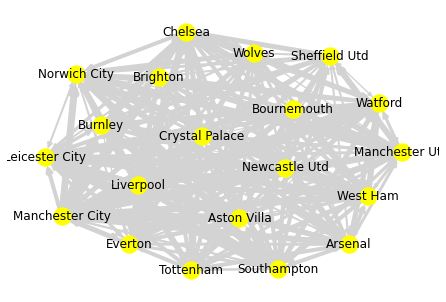

In [5]:
#Goals are considered edges pointing from the scorer to the target
Goals = nx.from_pandas_edgelist(goals_df, 
                            source = "score_team",
                            target = "target", 
                            create_using = nx.DiGraph,
                            edge_attr=['goals'])
width = [Goals[u][v]['goals'] for u,v in Goals.edges()]
pos = nx.spring_layout(Goals)
nx.draw(Goals,pos,with_labels=True, width = width, edge_color="lightgrey",
        font_size = 12,
        node_color = "yellow",
        arrows = True)
plt.savefig('Prem_dir_graph.png')
plt.show(block=False)


### PageRank

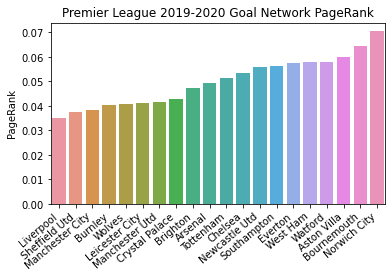

In [53]:
pr = nx.pagerank(Goals, alpha=1, weight = 'goals') #This data set has no teleportation
page_rank = pd.DataFrame(pr, index = ['PageRank'])
page_rank = page_rank.sort_values(by = 'PageRank', axis = 1)
plot = sns.barplot(data = page_rank)
plot.set_xticklabels(plot.get_xticklabels(), rotation=40, ha="right")
plt.ylabel('PageRank')
plt.title('Premier League 2019-2020 Goal Network PageRank')
plt.gcf().subplots_adjust(bottom=.25)
plt.savefig('Prem_PageRank.png')
plt.show(block=False)


In [54]:
display(page_rank.T)

,PageRank
Liverpool,0.034913
Sheffield Utd,0.037483
Manchester City,0.038369
Burnley,0.040490
Wolves,0.040863
Leicester City,0.041285
Manchester Utd,0.041591
Crystal Palace,0.042864
Brighton,0.047207
Arsenal,0.049382


The above pagerank data identifies Norwich City as the most visited member of the goalscoring network, although the 
overall distribution of the pagerank information is fairly even, with every team having a PageRank value of between
.03 and .075. Norwich City's high pagerank is indicative of them not only conceding many goals, but conceding a lot to
other teams with high pageranks(by this metric, bad teams), while also not scoring many goals. 
On the opposite end of this trend is Liverpool, the team with the lowest pagerank, likely due to their potent goalscoring season. The fact that Liverpool won the Premier League championship indicates that page_rank is a fairly accurate assessment of a teams quality in this season, although goals scored and concede does not perfectly translate to wins and losses.